# Томография 

В этом задании мы попробуем построить томограмму некоторого объекта, пользуясь данными об интенсивности лучей, прошедших через него.


In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sparse
import scipy.sparse.linalg as spla


### Генерация данных

Загрузим сечение анализируемой структуры из файла. Можно представлять, что мы анализируем, например, альвеолы в лёгких. Или колонию клеток.

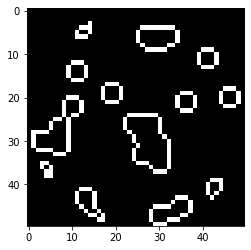

In [27]:
data = np.load("data/tomography.npy")
plt.imshow(data, cmap="gray")
n = data.shape[0]
assert (n, n) == data.shape

Томограф работает так: лучи испускаются из источника, проходят через анализируемую структуру и попадают на детектор (посмотрите картинки по [ссылке](https://plus.maths.org/content/saving-lives-mathematics-tomography)). По интенсивности луча, пришедшего в детектор можно понять, сколько энергии было поглощено по пути. В этой задаче мы будем считать, что количество поглощённой энергии пропорционально количеству пересечённых белых пикселей.

Мы хотим научиться считать величину $p_{\alpha, y}$ &mdash; количество белых пикселей, пересечённых прямой с заданным углом наклона $\alpha$ и проходящих через точку с координатой $(0, y)$ (оси $x,y$ проходят через центр картинки).


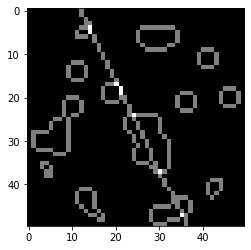

In [28]:
line = np.zeros((n,n))
I = np.arange(n)
J = (I * np.sin(np.pi/6) + n//4).astype(int)
mask = (J >= 0) & (J < n)
line[I[mask], J[mask]] = 1
_ = plt.imshow(data + line, cmap="gray")

Но делать это вычисление мы хотим одновременно для набора углов $\{\alpha_1, \dots, \alpha_s\}$ и набора координат $\{y_1, \dots, y_t\}$. Поэтому мы сформируем матрицу $P$ размера $st \times n^2$, которая при умножении на вытянутую в столбец картинку `data` даст столбец, состоящий из величин $p_{\alpha_i, y_j}$.

Систему координат мы разместим в центре картинки, ось X направим вверх, ось Y вправо. Таким, образом, точка $(x,y)$ примерно соответствует пикселю `data[y + n//2, -x + n//2]`. Реализуем функцию `build_projection_operator`, возвращающую матрицу $P$.

In [29]:
def build_projection_operator(n, alphas, ys):
    P = np.zeros((len(alphas) * len(ys), n**2))
    index = 0
    for alpha in alphas:
        tan = np.tan(alpha)
        cotan = np.tan(np.pi/2 - alpha)
        for y0 in ys:
            if np.abs(tan) <= 1:
                X = np.arange(-n//2, n//2)
                Y = y0 + X * tan
                mask = (Y > -n/2.) & (Y < n/.2)
            else:
                Y = np.arange(-n//2, n//2)
                X = (Y - y0) * cotan
                mask = (X > -n/2.) & (X < n/2.)
            X = np.clip(n//2 - X, 0, n - 1)
            Y = np.clip(Y + n//2, 0, n - 1)
            I = Y[mask].astype(np.int64)
            J = X[mask].astype(np.int64)
            P[index, I + J * n] = 1
            index += 1
    return P

In [30]:
n_alphas = 20
n_ys = 64
alphas = np.linspace(0, np.pi, num=n_alphas, endpoint=False)
ys = np.linspace(-n/2., n/2., num=n_ys)
P = build_projection_operator(n, alphas, ys)
P.shape

(1280, 2500)

Выведем несколько строк матрицы `P` в виде картинок и убедимся, что они соответствуют лучам томографа.

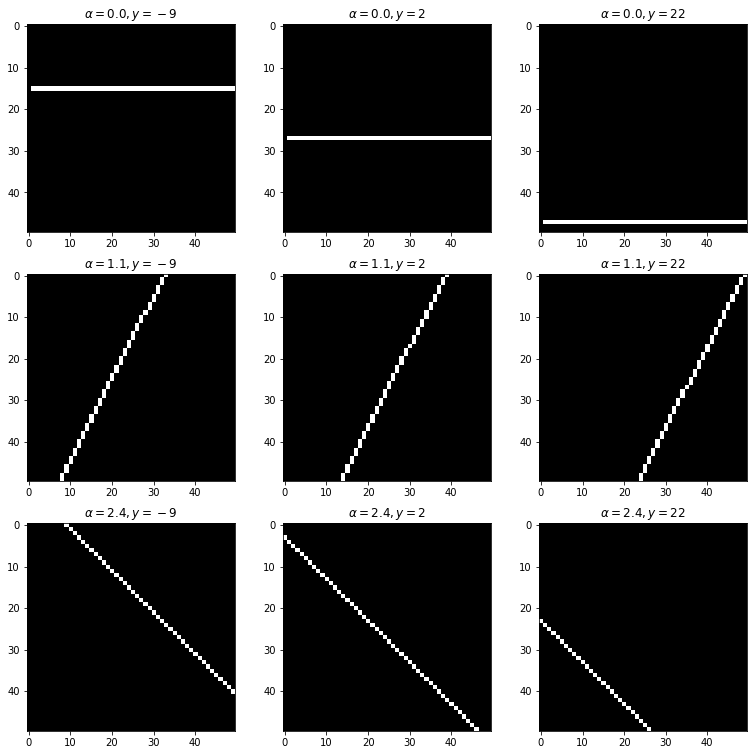

In [31]:
fig, axs = plt.subplots(3, 3, figsize=(13,13))
for i, i_alpha in enumerate([0, 7, 15]):
    for j, i_y in enumerate([20, 35, 60]):
        axs[i,j].imshow(np.reshape(P[i_y +  i_alpha * n_ys, :], (n, n)).T, cmap="gray")
        axs[i,j].set_title("$\\alpha = {:.2}, y = {}$".format(alphas[i_alpha], int(ys[i_y])))

  1.  Сформируйте проекцию, используя матрицу $P$ и исходную картинку `data`.

In [32]:
projection = P.dot(np.reshape(data, (n*n, 1),order = 'f'))

Порешейпим проекцию так, чтобы строки соответствовали углам $\alpha_i$, а столбцы &mdash; сдвигам $y_j$.

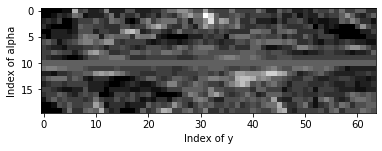

In [33]:
plt.imshow(np.reshape(projection, (n_ys, n_alphas), order="f").T, cmap="gray")
plt.xlabel("Index of y")
_ = plt.ylabel("Index of alpha")

### Получение томограммы по проекции

Для восстановления исходной структуры по проекциям, необходимо решить уравнение $Px = b$, где столбец $b$ содержит проекции.
Так как матрица $P$ имеет больше столбцов, чем строк, то система является **недоопределённой**, то есть одни и те же проекции могло дать бесконечно большое количество исходных структур $x$. Если же мы наложим дополнительное требование, чтобы 2-норма вектора $x$ была минимальна, то полученная задача
$$
\|x\|_2 \to \min_{Px=b}
$$
имеет известное решение $x = P^+b$. Поэтому в данном разделе вам необходимо найти псевдообратную матрицу к $P$. Так как в вычислениях с плавающей точкой задача нахождения псевдообратной является некорректно поставленной (из-за того, что сравнение сингулярных чисел с нулём не имеет смысла), то на практике обычно вычисляют $\delta$-псевдообратные матрицы. При их вычислении отбрасываются все сингулярные числа, меньшие $\delta$. Полученная матрица обозначается $P^+_\delta$.

Если исходная матрица имеет много малых сингулярных чисел, то имеет смысл не вычислять $P^+_\delta$ в явном виде, а использовать для вычислений компактное SVD этой матрицы, то есть разложение, в котором матрицы $U$ и $V$ имеют по $\mathrm{rank}(P^+_\delta)$ столбцов. Мы так и поступим.

   3. **(5 баллов)** Напишите функцию `pseudoinverse`, вычисляющую для заданной матрицы $P$ сингулярное разложение её $\delta$-псевдообратной.
Необходимо вернуть компактное SVD матрицы $P^+_\delta$.
Для вычисления используйте сингулярное разложение матрицы $P$. Использовать функцию `np.linalg.pinv` запрещено.

In [34]:
def pseudoinverse_svd(P, threshold=1e-15):
    """
        Input
            A: m x n array
            threshold: smaller singular values are to be dropped
        Output
            U: n x r array with orthonormal columns
            S: array of size r
            VT: r x m array with orthonormal rows
    """
    U,S,VT = np.linalg.svd(P, full_matrices=False)
    S[S < threshold] = 0
    S[S != 0] = S[S != 0]**(-1)
    return VT.T, S, U.T
    raise NotImplementedError()

Проверим, что псевдообратная совпадает с обратной для квадратной невырожденной матрицы $A$ (случайная матрица с вероятностью, очень близкой к единице, является невырожденной).

In [35]:
A = np.random.random((3, 3))
U, S, VT = pseudoinverse_svd(A)
pinv = np.multiply(U, S) @ VT
assert np.linalg.norm(pinv @ A - np.eye(3)) < 1e-12

   4.  С помощью сингулярного разложения $\delta$-псевдообратной к $P$ и вектора `tomogram` восстановите изображение. Для получения полного балла сложность вычисления восстановленного изображения должна быть $O(n^2r^2 + r(st)^2)$, где $r = \mathrm{rank}(P^+_\delta)$. Иными словами, нельзя формировать полную матрицу $P^+_\delta$. **Обратите внимание:** дефолтное значение параметра `threshold` не очень подходит для данной задачи, вместо этого рекомендуем использовать `threshold=1`.

In [36]:
U, S, VT = pseudoinverse_svd(P, threshold = 1)
reconstructed_pinv = np.multiply(U[:,:S.shape[0]], S) @ VT @ projection

Проверьте своё решение: убедитесь, что $\frac{\|P x_{reconstructed} - b\|_2}{\|b\|_2}$ не очень велико, а также выведите в виде изображения вектор `reconstructed_pinv`. На картинке должны достаточно чётко виднеться контуры объектов, особенно близких к центру (**опционально**: можете ли вы неформально объяснить тот эффект, что лучше восстанавливаются объекты, более близкие к центру?)

In [39]:
assert np.linalg.norm(P @ reconstructed_pinv - projection) / np.linalg.norm(projection) < 1e-2

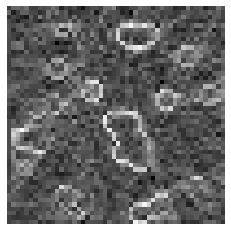

In [40]:
plt.imshow(reconstructed_pinv.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

### Ridge regression

Теперь попробуем подойти к восстановлению изображения с другой стороны: будем решать при фиксированном $\mu > 0$ так называемую $\ell_2$-регуляризованную задачу наименьших квадратов (в англоязычной литературе ridge regression):
$$
\|Px - b\|_2^2 + \mu \|x\|_2^2 \to \min
$$
($b$ здесь означает вектор `projection`).
Смысл состоит в том, что мы хотим, чтобы одновременно и $x$ давала проекцию, похожую на $b$, и при этом сам вектор $x$ не был слишком велик по норме.

Для решения этой задачи запишем условие равенства нулю градиента этой функции:
$$
2(Px-b)^\top P + 2\mu x^\top = 0 \Leftrightarrow (P^\top P + \mu I)x = P^\top b.
$$

   5. Используя компактное SVD $P$, напишите тело функции `ridge_regression`, решающую указанную задачу минимизации для заданных $P$, $b$ и $\mu$. Для получения полного балла не формируйте нигде матриц размером $n^2 \times n^2$.

In [41]:
def ridge_regression(P, b, mu):
    """
        Input
            P: m x n numpy array
            b: numpy array of size m
            mu: regularization coefficient

        Output
            x: numpy array of size n solving ridge regression problem
    """
    U, S, VT = np.linalg.svd(P, full_matrices=True)

    
#     Я пытался не формировать матрицу n^2 на n^2, использовал формулу из 3 теор. задачи, но что-то не получилось...

#     inv_temp = (S + mu * (S ** (-1)))**(-1) - S**(-1)
#     return (inv_temp * np.eye(inv_temp.shape[0])) @ VT.T @ U.T @ b
#     return (VT.T @ (inv_temp* np.eye(inv_temp.shape[0])) @ U.T + P.T) @ b

    return np.linalg.inv(P.T @ P + mu * np.eye(P.shape[1])) @ P.T @ b 
    raise NotImplementedError()

In [42]:
reconstructed_ridge = ridge_regression(P, projection, 1)

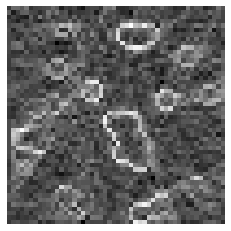

In [43]:
plt.imshow(reconstructed_ridge.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

Обратите внимание, насколько похож результат решения задачи ridge regression на решение с помощью псевдообратной. Это неслучайно: можно показать, что эти два подхода тесно взаимосвязаны, а в пределе при $\mu, \delta \to 0$ дают одинаковые векторы.

### Lasso

Если в ridge regression вместо квадрата второй нормы $x$ использовать первую норму (то есть ставить $\ell_1$-регуляризованную задачу наименьших квадратов), то получится такая задача минимизации:
$$
\|Px-b\|_2^2 + \mu \|x\|_1 \to \min.
$$

Такая задача оказывается более подходящей в нашем случае, так как её решение часто оказывается разреженным (получить некоторую интуицию о том, почему так происходит, можно, например, [тут](https://medium.com/analytics-vidhya/intuition-behind-l1-l2-regularisation-2ac1e6a1bd81); более развёрнутое описание метода есть в [википедии](https://en.wikipedia.org/wiki/Lasso_(statistics))).

   6. Заполните пропуски в теле функции `solve_lasso`. Воспользуйтесь документацией к классу [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).


In [1]:
from sklearn.linear_model import Lasso

def solve_lasso(P, b):
    lasso = Lasso(alpha=0.001)
    lasso.fit(P, b)
    return lasso.coef_

In [45]:
reconstructed_lasso = solve_lasso(P, projection)

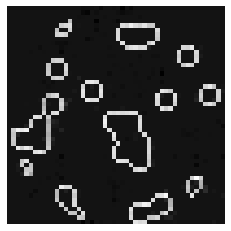

In [46]:
plt.imshow(reconstructed_lasso.reshape(n, n, order='f'), cmap='gray'); _ = plt.axis('off')

Сравним все три полученных решения с исходной структурой.

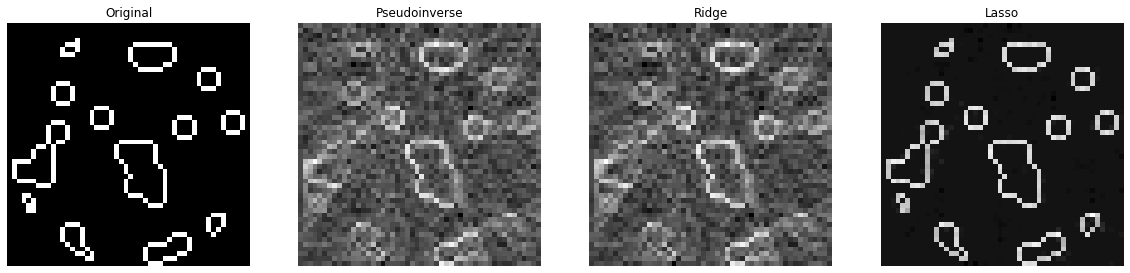

In [47]:
fig, axs = plt.subplots(1,4, figsize=(20,30))
for i, (im, name) in enumerate([
    (data, "Original"),
    (reconstructed_pinv.reshape(n, n, order='f'), "Pseudoinverse"),
    (reconstructed_ridge.reshape(n, n, order='f'), "Ridge"),
    (reconstructed_lasso.reshape(n, n, order='f'), "Lasso"),
]):
    axs[i].imshow(im, cmap="gray")
    axs[i].set_title(name)
    axs[i].axis('off')

# Быстрое вычисление дискретной свертки

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

**Обратите внимание:** <font color='red'>во всех пунктах данной задачи запрещается использовать циклы.</font>

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

(256, 256)


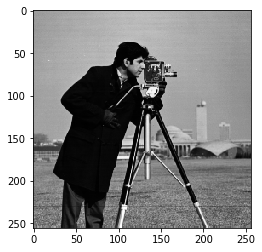

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(np.float64)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

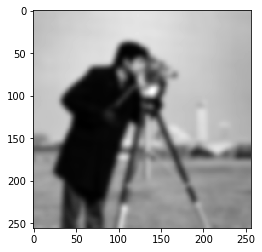

In [49]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть $$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).



### b.  Имплементация одномерных сверток

-  Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своей первой строки. При вычислениях нигде не должна возникнуть полная матрица $T_m$.

In [50]:
def convolve_1D(A, T_row):
    """
        Input
            A: m x n matrix
            T_row: array of shape (m,) -- first row of matrix T_m

        Output
            B: m x n matrix, B = T_m @ A
    """
    c = np.concatenate([T_row, T_row[:0:-1]], axis = 0)
    x = np.concatenate([A, np.zeros((T_row.shape[0] - 1, A.shape[1]))], axis = 0)
    return np.fft.ifft(np.diag(np.fft.fft(c,axis = 0)) @ np.fft.fft(x, axis = 0), axis = 0)[:T_row.shape[0]]

Напишем также функцию `form_T_row`, которая будет создавать первую строку матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

In [51]:
from scipy.linalg import toeplitz

def form_T_row(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_row: array of shape (m,) -- first row of T_m, 
                   the matrix of 1D Gaussian filter
    """
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp((-1. / sigma**2) * np.arange(m)**2)
    
def form_T(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_m: m x m matrix of 1D gaussian filter
    """
    return toeplitz(form_T_row(m, sigma))

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [52]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_row = form_T_row(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_row))

2.2474722514611155e-14

-  Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.

Исходя из того, что вектор $T_m$ длины m, а для матрицы A нам нужно преобразовать n столбцов, общая сложность получится
$$
O(mn \cdot log(m))
$$

- Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильную строку `T_row` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [53]:
def gauss_convolve_1D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            B: m x n matrix, B = G_m @ A
    """
    
    T_row = form_T_row(A.shape[0], sigma)
    return convolve_1D(A, T_row).astype(np.float64).reshape((A.shape[0],A.shape[1]))

-  Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


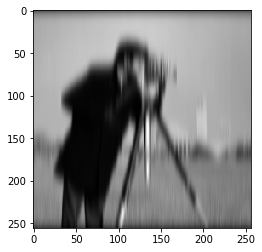

In [54]:
A_conv_1D = gauss_convolve_1D(A, 10)
_ = plt.imshow(A_conv_1D, cmap='gray')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


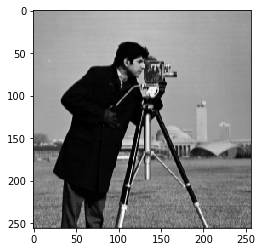

In [55]:
A_conv_1D = gauss_convolve_1D(A, 1)
_ = plt.imshow(A_conv_1D, cmap='gray')

Данная формула для $T_m$ ни что иное, как формула для стандартного нормального распределения. Сигма - стандартное отклонение. Чем больше сигма - тем больше разброс и отклонение. При нормальном распределении с матожиданием 0 и дисперсией - 1 (среднее отклонение 1), частоты будут распределяться равномерно и картинка не будет размыта. 

В данном случае мы делаем свёртку по столбцам и наши частоты можно соотнести с фотографией как-то так.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


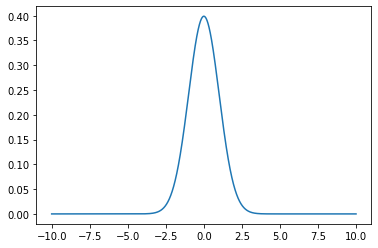

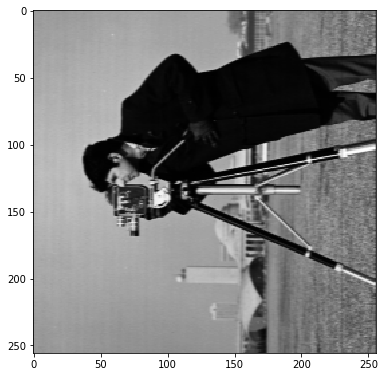

In [56]:
from scipy.stats import norm
x_axis = np.arange(-10, 10, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1))
A_conv_1D = gauss_convolve_1D(A, 1)
plt.show()
plt.figure(figsize=(6.3,6.3))
_ = plt.imshow(A_conv_1D.T, cmap='gray')

Соответственно, если увеличить дисперсию - график растянется и частоты "наедут друг на друга".

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


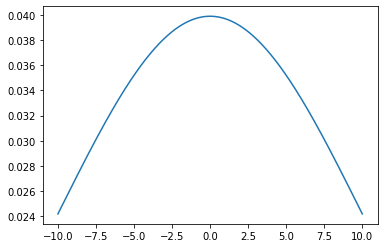

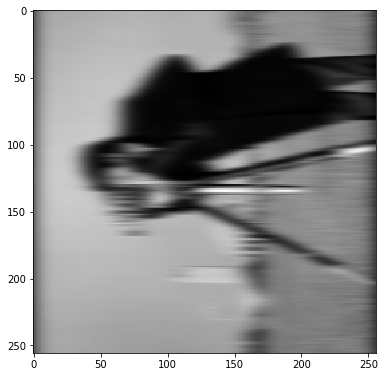

In [57]:
from scipy.stats import norm
x_axis = np.arange(-10, 10, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,10))

A_conv_1D = gauss_convolve_1D(A, 10)
plt.show()
plt.figure(figsize=(6.3,6.3))
_ = plt.imshow(A_conv_1D.T, cmap='gray')

### c.  Вычисление двумерной свертки

- Теперь вы уже без труда сможете написать функцию двумерной свёртки: $B = T_m A T_n^T$ ...

In [58]:
def gauss_convolve_2D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            С: m x n matrix, B = G_m @ A @ G_n.T
    """
    T_m_row = form_T_row(A.shape[0], sigma)
    T_n_row = form_T_row(A.shape[1], sigma)
    T_m_A = convolve_1D(A, T_m_row).astype(np.float64).reshape((A.shape[0],A.shape[1]))
    return convolve_1D(T_m_A.T, T_n_row).astype(np.float64).reshape((A.shape[0],A.shape[1])).T

...и визуально проверить, правильно ли она работает.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


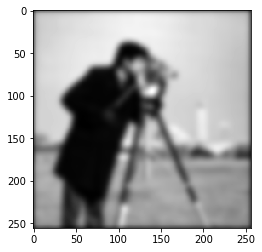

In [59]:
A_conv = gauss_convolve_2D(A, 5)
_ = plt.imshow(A_conv, cmap='gray')

-  Объясните эффект тёмных полос около края картинки.

Поскольку за картинкой у нас нулевые края, то в боковые пиксели приходит меньше сумма дельт от свёртки. Для исправления этого эффекта рекомендуют отражать картинку во все четыре стороны и склеивать боковой стороной.

### d. Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


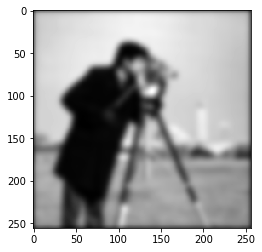

In [60]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma)
_ = plt.imshow(A_conv, cmap='gray')

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [61]:
m, n = A_conv.shape
T_m, T_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(T_m, A_conv)
A_rec = np.linalg.solve(T_n, B.T).T

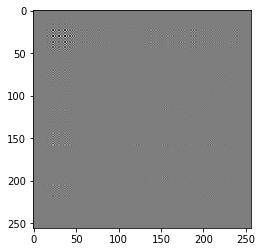

In [62]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $G_m$.

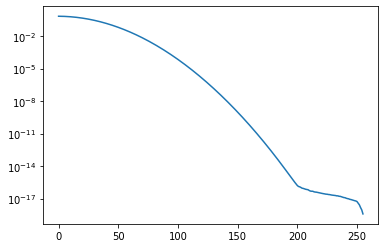

In [63]:
s = np.linalg.svd(T_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы (хотя пока мы не умеем это формализовывать), потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить "приближённый" $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся (легко проверить) тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

-  Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирут изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```. **Замечание:** В данном случае ```np.linalg.pinv``` выдаст всю псевдообратную матрицу, что подойдет в качестве решения. Но можно сделать немного эффективнее, если явно умножать на компоненты компактного SVD. 

In [64]:
def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    """
        Input
            conv: m x n matrix -- result of convolution with
                  a Gaussian filter
            sigma: standard deviation of Gaussian filter
            tol: tolerance for cutting singular values in pseudoinverse

        Output
            A_rec: m x n reconstructed matrix, such that approximately A_conv = T_m @ A_rec @ T_n.T
    
    """
    
    T_m = form_T(A_conv.shape[0], sigma)
    T_n = form_T(A_conv.shape[1], sigma)
    
    U, S, VT = pseudoinverse_svd(T_m, tol)
    U_, S_, VT_ = pseudoinverse_svd(T_n, tol)
    
    T_m = np.multiply(U,S) @ VT
    T_n = np.multiply(U_,S_) @ VT_
    
    return T_m @ A_conv @ T_n.T

Посмотрим на получившийся результат.

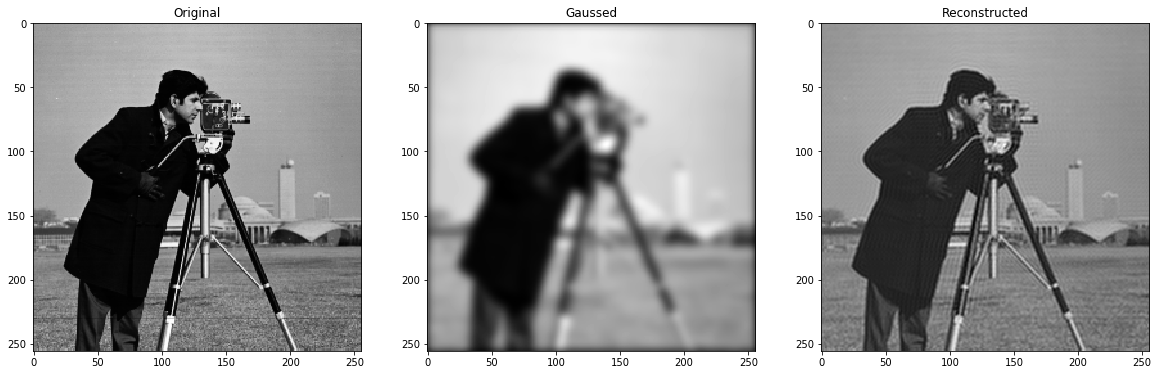

In [65]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(A_conv, cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(A_rec, cmap='gray')
_ = axs[2].set_title("Reconstructed")